In [6]:
import pandas as pd
import os
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import scipy.stats as stats

In [7]:
salary = pd.read_csv('../data/SalaryData.csv')
citations_2023 = pd.read_csv('../data/citations_20-23.csv')
officer_number = pd.read_csv('../data/sworn_officers.csv')

/var/folders/2d/yt4_w6zn5pbfjg_jx5sdmm180000gn/T/ipykernel_49563/3343701511.py:2: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  citations_2023 = pd.read_csv('../data/citations_20-23.csv')


### Function list and what they do
| Function | Description |
|:----- | ---------- |
| officer_number_cleaning| Cleans Officer names and badge number  |
| officer_number_test| Tests that the columns where created correctly |
| cleaned_salary| Calculates rates of pay, time worked, cleans names, and limits to LMPD |
| merge_salary_officer_number | Merges the officers badge number to the salary sheets |
| year_selector | This allows us to make new dataframes for the selected year we want |

In [8]:
'''
Cleans and prepares officer data by splitting a combined column into separate columns for badge number, first name, and last name. 
The function then renames these columns for consistency before returning the modified DataFrame.
'''
def officer_number_cleaning(df) -> pd.DataFrame:
  # Split the single column into the correct 3 and deletes the old column
  officer_number[['badge', 'fname', 'lname']] = officer_number['badge fname lname'].str.split(n=2, expand=True)
  officer_number.drop(columns=['badge fname lname'], inplace=True, errors='ignore')

  # Rename columns in officer_number for merging
  officer_number.rename(columns={'fname': 'First_Name', 'lname': 'Last_Name'}, inplace=True)
  return df 


'''
Validates the structure of an officer DataFrame by checking if it contains the expected columns. 
Prints a message indicating whether the columns match the expected structure.
'''
def officer_number_test(df) -> pd.DataFrame:
    # Define expected columns for validation then validates
  expected_cols = ['badge',	'First_Name', 'Last_Name']
  if list(officer_number.columns) != expected_cols:
      print("Columns don't match; expected columns for this project are:", expected_cols)
  else:
      print("Columns match the expected structure.")


'''
Cleans and enhances salary data by calculating hourly rates, estimating hours worked, and splitting 
employee names into separate columns. Filters the data to include only police departments.
'''
def cleaned_salary(salary) -> pd.DataFrame:
    salary = salary.copy()

    # Calculate hourly rates and hours worked
    salary['Hr_Rate'] = salary['Regular_Rate'] / 2080
    salary['Ot_Rate'] = salary['Hr_Rate'] * 1.5
    
    # Ensure 'Overtime_Rate' is in the DataFrame before calculation
    if 'Overtime_Rate' in salary.columns:
        salary['Hr_Worked'] = salary['Overtime_Rate'] / salary['Ot_Rate'] / 52 + 40
    else:
        salary['Hr_Worked'] = 40  # Default to 40 if 'Overtime_Rate' is not available

    salary.replace([np.inf, -np.inf], 40, inplace=True)

    # Split name to first, middle, and last
    salary[['Last_Name', 'First_Middle_Names']] = salary['Employee_Name'].str.split(', ', expand=True)
    salary[['First_Name', 'Middle_Name']] = salary['First_Middle_Names'].str.split(' ', n=1, expand=True)
    salary['Middle_Name'] = salary['Middle_Name'].fillna('')
    salary = salary.drop(columns=['First_Middle_Names'])

    # Limit the data to LMPD
    departments_of_interest = [
        'Louisville Metro Police',
        'Louisville Metro Police Department',
    ]
    salary = salary[salary['Department'].isin(departments_of_interest)]

    return salary


'''
Merges salary and officer number data by matching first and last names, cleans up whitespace and 
case inconsistencies for accurate merging, and adds officer badge numbers to the salary data. 
The merged DataFrame is then sorted by hours worked.
'''
def merge_salary_officer_number(salary, officer_number) -> pd.DataFrame:
    # Strip whitespace to make all the joins work 
    salary['First_Name'] = salary['First_Name'].astype(str).str.strip().str.lower()
    salary['Last_Name'] = salary['Last_Name'].astype(str).str.strip().str.lower()

    officer_number['First_Name'] = officer_number['First_Name'].astype(str).str.strip().str.lower()
    officer_number['Last_Name'] = officer_number['Last_Name'].astype(str).str.strip().str.lower()

    # Perform the merge
    salary = salary.merge(officer_number[['First_Name', 'Last_Name', 'badge']],
                          on=['First_Name', 'Last_Name'], 
                          how='left')

    # Rename 'badge' column to 'badge_number'
    salary.rename(columns={'badge':'badge_number'}, inplace=True)

    # Sorting by hours worked
    salary = salary.sort_values(by='Hr_Worked', ascending=False)
    return salary


'''
Filters the salary data to include only records for the specified year.
'''
def year_selector(salary, year) -> pd.DataFrame:
    # Filter the salary data for the selected year
    salary = salary[salary['CalYear'] == year]
    return salary

'''
Cleans and processes citation data for 2023 by:
- Mapping and standardizing race values in the 'PERSONS_RACE' column.
- Dropping unnecessary columns.
- Grouping the data by 'BADGE_ID' and aggregating information such as the number of tickets issued and 
  counts of female and male drivers, as well as counts for each race category (White, Black, Asian, and Unknown).
- Calculating the percentage of female and male drivers for each badge ID.
- Sorting the data by the number of tickets issued in descending order.
'''
def citation_cleaning(citations_2023) -> pd.DataFrame:
    citation_cols_to_drop = ['AGENCY_DESC', 'CASE_NUMBER', 'CITATION_YEAR',
        'CITATION_CONTROL_NUMBER', 'CITATION_TYPE_DESC', 'CITATION_DATE',
        'CITATION_LOCATION', 'DIVISION', 'BEAT', 'PERSONS_HOME_CITY',
        'PERSONS_ETHNICITY', 'PERSONS_AGE', 'ASCF_CODE',
        'PERSONS_HOME_STATE', 'PERSONS_HOME_ZIP', 'UCR_CODE', 'UCR_DESC', 'VIOLATION_CODE', 'STATUTE', 'ObjectId']


    race_mapping = {
            'W': 'WHITE',
            'B': 'BLACK',
            'H': 'HISPANIC',
            'A': 'ASIAN',
            'U': 'UNKNOWN'
        }
    citations_2023['PERSONS_RACE'] = citations_2023['PERSONS_RACE'].str.strip().map(race_mapping)

    citations_2023 = citations_2023.drop(citation_cols_to_drop, axis=1, errors='ignore') 

    # Grouping by BADGE_ID and aggregating
    citations_2023 = citations_2023.groupby('BADGE_ID').agg(
        number_of_tickets = ('BADGE_ID', 'size'),
        Female_Drivers = ('PERSONS_SEX', lambda x: (x == 'F').sum()),
        Male_Drivers = ('PERSONS_SEX', lambda x: (x == 'M').sum()),
        White_Drivers = ('PERSONS_RACE', lambda x: (x == 'WHITE').sum()),
        Black_Drivers = ('PERSONS_RACE', lambda x: (x == 'BLACK').sum()),
        Asian_Drivers = ('PERSONS_RACE', lambda x: (x == 'ASAIN').sum()),
        Unknown_Drivers = ('PERSONS_RACE', lambda x: (x == 'UNKNOWN').sum()),
    ).reset_index()

    # Calculate percentages
    citations_2023['Female_Percentage'] = (citations_2023['Female_Drivers'] / citations_2023['number_of_tickets'] * 100).astype(float)
    citations_2023['Male_Percentage'] = (citations_2023['Male_Drivers'] / citations_2023['number_of_tickets'] * 100).astype(float)

    citations_2023 = citations_2023.sort_values(by='number_of_tickets', ascending=False)
    return citations_2023


'''
Final merge merging on badge number
'''
def final_merge(salary_with_officer, cleaned_citation_23) -> pd.DataFrame:
  # Convert both columns to string type
  salary_with_officer['badge_number'] = salary_with_officer['badge_number'].astype(str)
  cleaned_citation_23['BADGE_ID'] = cleaned_citation_23['BADGE_ID'].astype(str)

  # Now perform the merge
  cleaned_final = salary_with_officer.merge(cleaned_citation_23, left_on='badge_number', right_on='BADGE_ID', how='left')
  return cleaned_final


In [9]:
officer_number =  officer_number_cleaning(officer_number)
officer_number_test(officer_number)
salary = cleaned_salary(salary)
salary_with_officer = merge_salary_officer_number(salary, officer_number)
cleaned_citation_23 = citation_cleaning(citations_2023)
cleaned_final = final_merge(salary_with_officer, cleaned_citation_23)
cleaned_final.head()

Columns match the expected structure.


,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,Other,YTD_Total,...,BADGE_ID,number_of_tickets,Female_Drivers,Male_Drivers,White_Drivers,Black_Drivers,Asian_Drivers,Unknown_Drivers,Female_Percentage,Male_Percentage
0,2024,"Jenkins, Todd Barry",Louisville Metro Police Department,Police Sergeant,104332.8,81943.74,134138.76,8950.43,NaN,225032.93,...,7785,152.0,56.0,96.0,112.0,30.0,0.0,4.0,36.842105,63.157895
1,2024,"Fey, Ronald W",Louisville Metro Police Department,Police Sergeant,102627.2,64989.33,97713.51,6800.21,NaN,189333.14,...,7578,14853.0,5323.0,9530.0,9881.0,4757.0,0.0,4.0,35.837878,64.162122
2,2024,"Ernst, Eric Michael",Louisville Metro Police Department,Police Officer,91000.0,68413.52,102671.38,8485.70,NaN,179767.16,...,2969,247.0,115.0,132.0,202.0,38.0,0.0,0.0,46.558704,53.441296
3,2020,"Patterson, William",Louisville Metro Police,Police Sergeant,71448.0,9691.28,14040.60,4240.80,NaN,39694.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024,"Fenwick, Paul E",Louisville Metro Police Department,Police Officer,91000.0,69236.23,97053.71,8210.10,NaN,174500.04,...,2569,25.0,6.0,19.0,3.0,21.0,0.0,0.0,24.000000,76.000000


In [10]:
print(f'columns in cleaned_final: \n {cleaned_final.columns}')

columns in cleaned_final: 
 Index(['CalYear', 'Employee_Name', 'Department', 'jobTitle', 'Annual_Rate',
       'Regular_Rate', 'Overtime_Rate', 'Incentive_Allowance', 'Other',
       'YTD_Total', 'ObjectId', 'Hr_Rate', 'Ot_Rate', 'Hr_Worked', 'Last_Name',
       'First_Name', 'Middle_Name', 'badge_number', 'BADGE_ID',
       'number_of_tickets', 'Female_Drivers', 'Male_Drivers', 'White_Drivers',
       'Black_Drivers', 'Asian_Drivers', 'Unknown_Drivers',
       'Female_Percentage', 'Male_Percentage'],
      dtype='object')


In [12]:
# to check sal for year
salary_2023 = year_selector(salary_with_officer, 2023)

In [13]:
cleaned_final = cleaned_final[cleaned_final['CalYear'] == 2023]
cleaned_final.head(2)

,CalYear,Employee_Name,Department,jobTitle,Annual_Rate,Regular_Rate,Overtime_Rate,Incentive_Allowance,Other,YTD_Total,...,BADGE_ID,number_of_tickets,Female_Drivers,Male_Drivers,White_Drivers,Black_Drivers,Asian_Drivers,Unknown_Drivers,Female_Percentage,Male_Percentage
7,2023,"Williams, Derrick D",Louisville Metro Police Department,Police Officer,80745.6,72354.57,96567.53,10524.01,NaN,180551.11,...,7648,45.0,0.0,45.0,20.0,25.0,0.0,0.0,0.000000,100.000000
9,2023,"Jenkins, Todd Barry",Louisville Metro Police Department,Police Sergeant,99382.4,94284.36,121917.23,9954.58,NaN,226221.17,...,7785,152.0,56.0,96.0,112.0,30.0,0.0,4.0,36.842105,63.157895


In [14]:
correlation_value = cleaned_final['Hr_Worked'].corr(cleaned_final['number_of_tickets'])
print(correlation_value)


0.21512140031827542


The correlation value of 0.2151 between hours worked and number of tickets indicates a weak positive relationship between the two variables. This suggests that, although there is a slight tendency for officers who work more hours to write more tickets, the strength of the correlation is not strong. Other factors might influence the number of tickets written, and this correlation alone doesn't suggest a strong predictive relationship.

In [15]:
# Convert the columns to integers
cleaned_final.columns = cleaned_final.columns.str.strip()
cleaned_final['Hr_Worked'] = cleaned_final['Hr_Worked'].fillna(0)
cleaned_final['number_of_tickets'] = cleaned_final['number_of_tickets'].fillna(0)
cleaned_final['Hr_Worked'] = cleaned_final['Hr_Worked'].astype(int)
cleaned_final['number_of_tickets'] = cleaned_final['number_of_tickets'].astype(int)
cleaned_final = cleaned_final[(cleaned_final['Hr_Worked'] != 0) & (cleaned_final['number_of_tickets'] != 0)]

In [16]:
# Calculate the Pearson correlation and p-value
correlation_value, p_value = stats.pearsonr(cleaned_final['Hr_Worked'], cleaned_final['number_of_tickets'])

# Print the results
print(f"Correlation value: {correlation_value}")
print(f"P-value: {p_value}")


Correlation value: 0.21470614923475842
P-value: 2.868762808001042e-10


Removed 0 values on number of tickets to remove high ranking officers or detectives who may not write tickets. 

- **Correlation value:** 0.2147, which is still a weak positive correlation between Hr_Worked (hours worked) and number_of_tickets (tickets written). There's a slight tendency for officers who work more hours to write more tickets, but the relationship is not strong.

- **P-value:** $2.87 \times 10^{-10}$ , which is very small and indicates that the correlation is statistically significant. This means the observed correlation is highly unlikely to be due to random chance, confirming that there's a meaningful relationship between the variables.

The drop of rows with zeros improved the analysis by removing potentially uninformative data points. Although the correlation is still weak, the statistical significance is strong.



In [17]:
cleaned_final.shape

(845, 28)

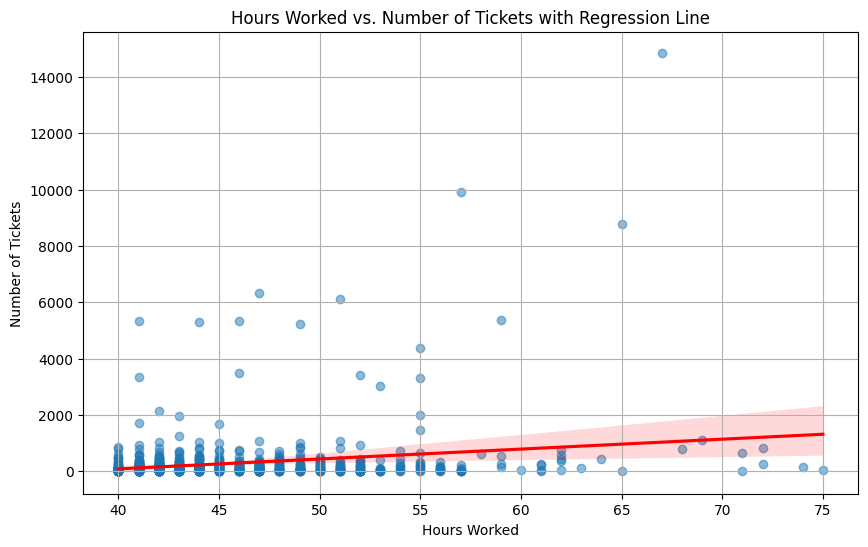

In [18]:
plt.figure(figsize=(10, 6))
sns.regplot(data=cleaned_final, x='Hr_Worked', y='number_of_tickets', scatter_kws={'alpha': 0.5}, line_kws={"color": "red"})
plt.title('Hours Worked vs. Number of Tickets with Regression Line')
plt.xlabel('Hours Worked')
plt.ylabel('Number of Tickets')
plt.grid()
plt.show()


# Hours to tickets

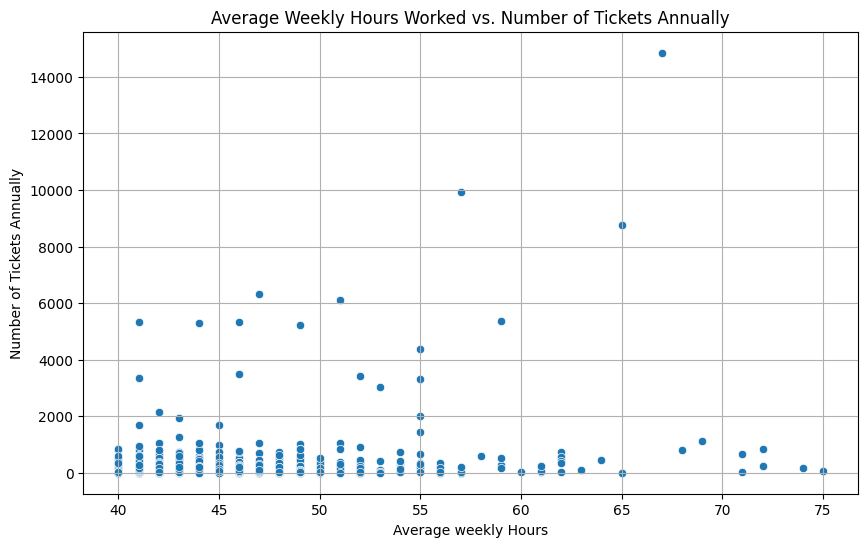

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_final, x='Hr_Worked', y='number_of_tickets')
plt.title('Average Weekly Hours Worked vs. Number of Tickets Annually')
plt.xlabel('Average weekly Hours')
plt.ylabel('Number of Tickets Annually')
plt.grid()
plt.show()


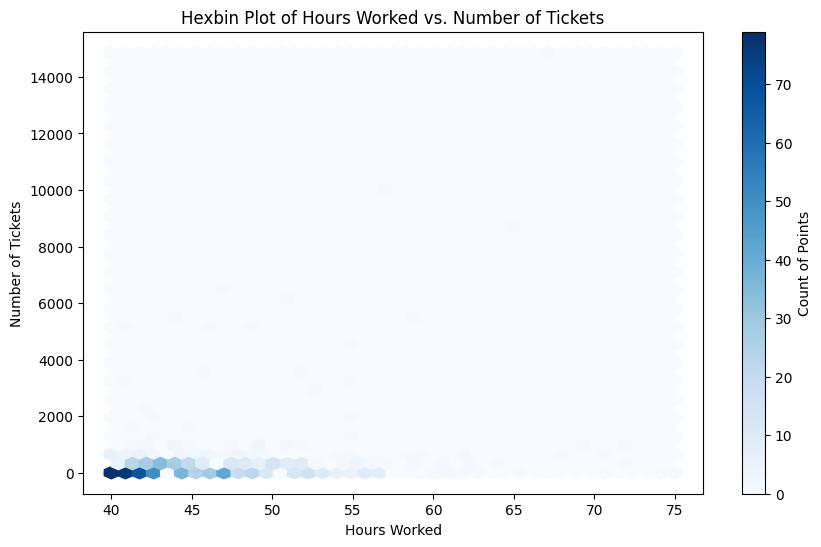

In [20]:
plt.figure(figsize=(10, 6))
plt.hexbin(cleaned_final['Hr_Worked'], cleaned_final['number_of_tickets'], gridsize=40, cmap='Blues')
plt.colorbar(label='Count of Points')
plt.title('Hexbin Plot of Hours Worked vs. Number of Tickets')
plt.xlabel('Hours Worked')
plt.ylabel('Number of Tickets')
plt.grid(False)
plt.show()


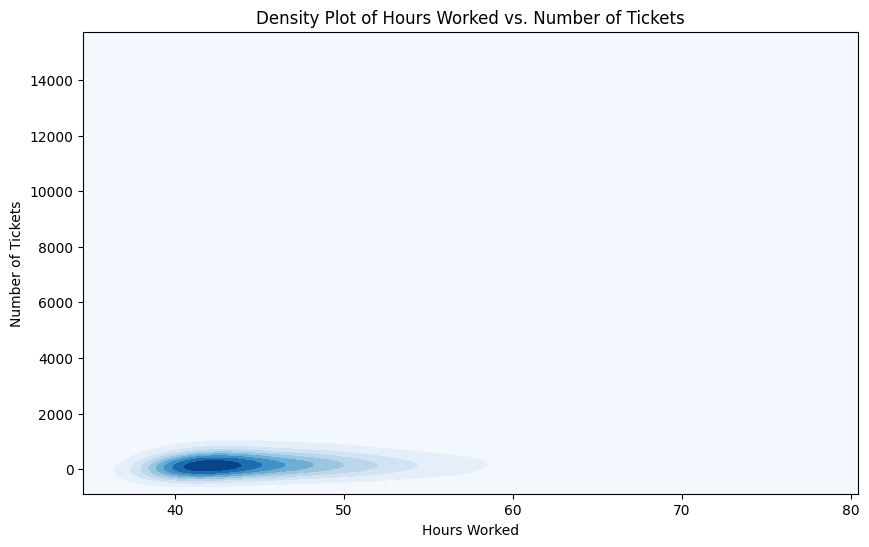

In [21]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=cleaned_final, x='Hr_Worked', y='number_of_tickets', fill=True, cmap='Blues', thresh=0)
plt.title('Density Plot of Hours Worked vs. Number of Tickets')
plt.xlabel('Hours Worked')
plt.ylabel('Number of Tickets')
plt.show()


# hours to pay

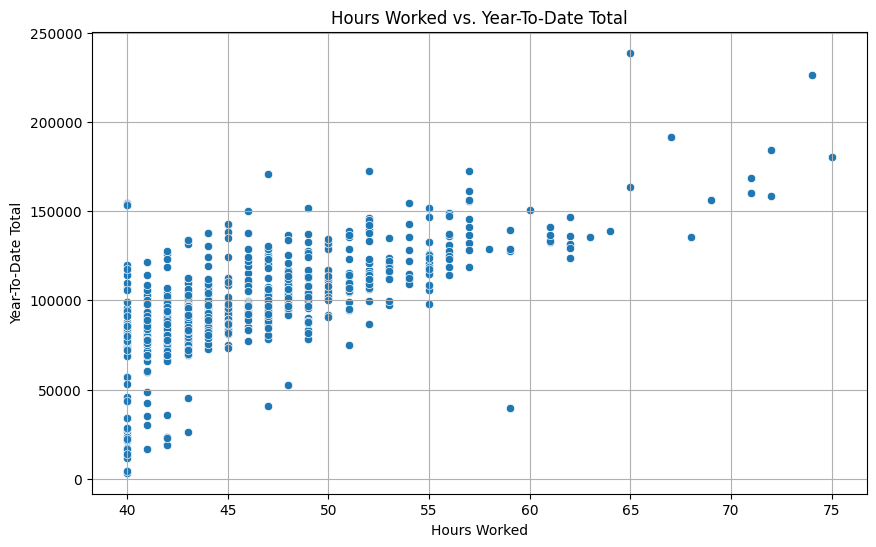

In [22]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleaned_final, x='Hr_Worked', y='YTD_Total')
plt.title('Hours Worked vs. Year-To-Date Total')
plt.xlabel('Hours Worked')
plt.ylabel('Year-To-Date Total')
plt.grid()
plt.show()


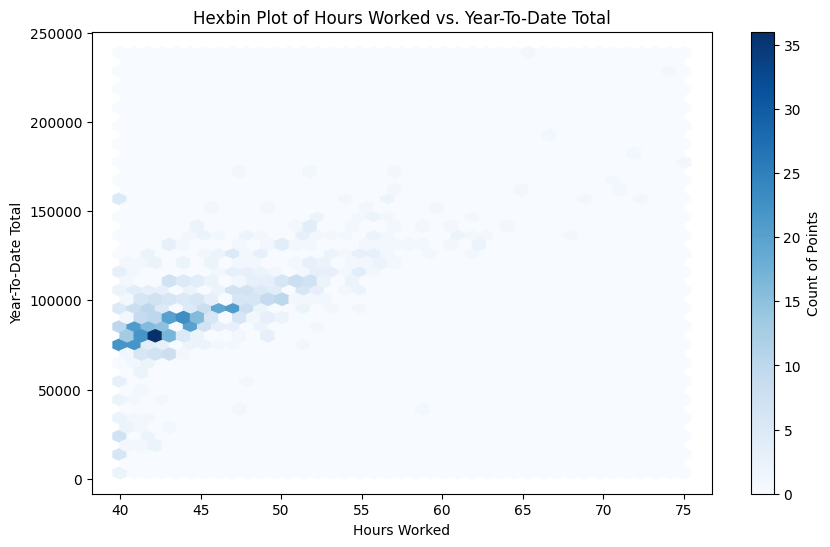

In [23]:
plt.figure(figsize=(10, 6))
plt.hexbin(cleaned_final['Hr_Worked'], cleaned_final['YTD_Total'], gridsize=40, cmap='Blues')
plt.colorbar(label='Count of Points')
plt.title('Hexbin Plot of Hours Worked vs. Year-To-Date Total')
plt.xlabel('Hours Worked')
plt.ylabel('Year-To-Date Total')
plt.grid(False)
plt.show()


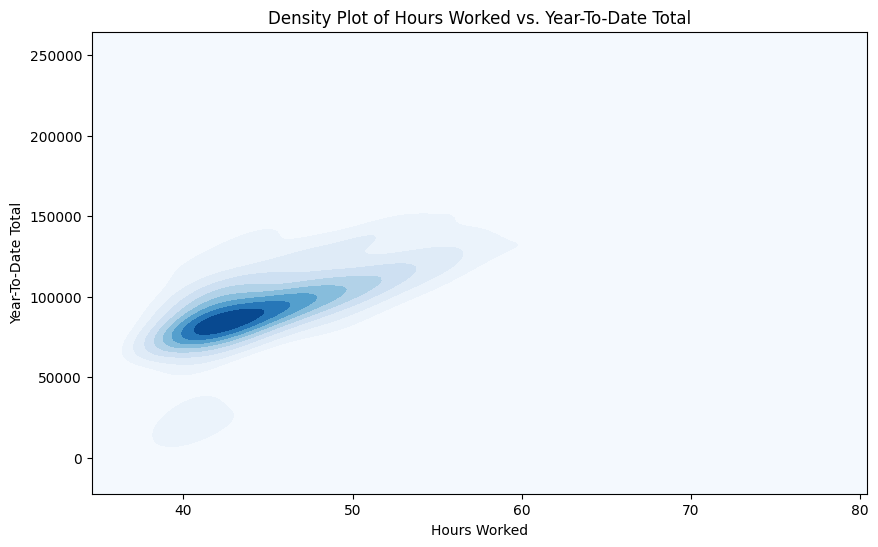

In [24]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=cleaned_final, x='Hr_Worked', y='YTD_Total', fill=True, cmap='Blues', thresh=0)
plt.title('Density Plot of Hours Worked vs. Year-To-Date Total')
plt.xlabel('Hours Worked')
plt.ylabel('Year-To-Date Total')
plt.show()



The weak correlation coefficients of 0.29 (Pearson) and 0.14 (Spearman) suggest that there is only a slight positive relationship between hours worked and the number of tickets handled, indicating that increased hours do not consistently lead to more tickets. However, correlation does not imply causation, and these results do not definitively prove that working more hours does not result in handling more tickets.

In [25]:
correlation = cleaned_final['Hr_Worked'].corr(cleaned_final['number_of_tickets'])
print(f'Correlation between Hours Worked and Number of Tickets: {correlation:.2f}')


Correlation between Hours Worked and Number of Tickets: 0.21


In [26]:
spearman_correlation = cleaned_final['Hr_Worked'].corr(cleaned_final['number_of_tickets'], method='spearman')
print(f'Spearman Correlation: {spearman_correlation:.2f}')

Spearman Correlation: 0.11


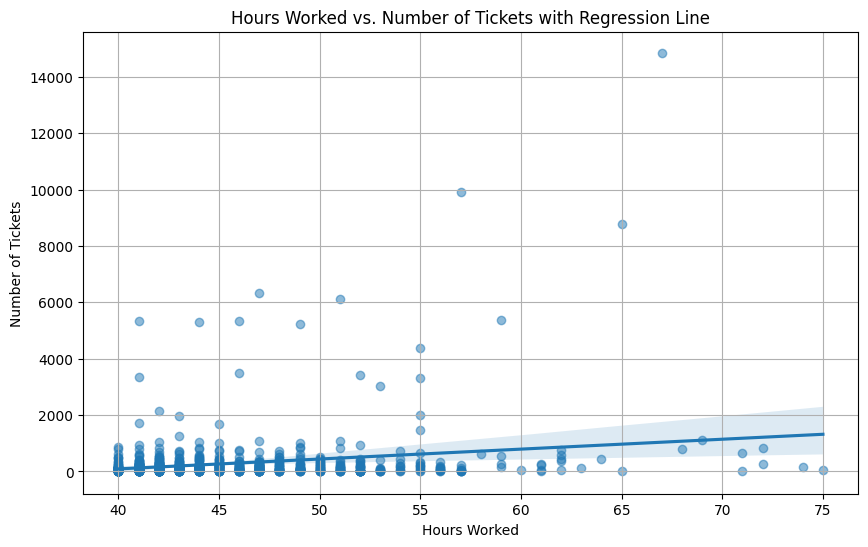

In [27]:
plt.figure(figsize=(10, 6))
sns.regplot(data=cleaned_final, x='Hr_Worked', y='number_of_tickets', scatter_kws={'alpha': 0.5})
plt.title('Hours Worked vs. Number of Tickets with Regression Line')
plt.xlabel('Hours Worked')
plt.ylabel('Number of Tickets')
plt.grid()
plt.show()
